# Predicting brain activity from word embeddings during natural language comprehension
This tutorial introduces a typical **enc**oding framework for mapping **ling**uistic embeddings onto human brain activity during natural language comprehension. The tutorial includes worked examples for both fMRI and ECoG datasets collected while subjects listened to naturalistic spoken narratives. Two types of word embeddings are obtained based on the stimulus transcripts: static word embeddings from word2vec and contextual word embeddings from GPT-2. Encoding models are estimated using banded ridge regression—this allows us to predict brain activity from word embeddings for left-out segments of data.

*Acknowledgments:* This tutorial draws heavily on work by co-author Zaid Zada (e.g. code from [Zada et al., 2023](https://doi.org/10.1101/2023.06.27.546708)) as well as Gallant Lab's [voxelwise modeling tutorials](https://gallantlab.org/voxelwise_tutorials/index.html) ([Dupré La Tour et al., 2022](https://doi.org/10.1016/j.neuroimage.2022.119728)).

---

First, we'll install the necessary packages for this tutorial. After that, we'll import some general-purpose Python packages. Typically, you should import all of your packages at the beginning of a script; here, we'll import packages we need as we go. We'll also download some fMRI data, ECoG data, and the accompanying transcripts from Zenodo.

In [6]:
# Install packages not already in Colab
# !pip install transformers accelerate
# !pip install himalaya voxelwise_tutorials
# !pip install nilearn surfplot neuromaps mne
# !pip install jupyter_bokeh

In [7]:
# # Some black magic to keep surfplot / VTK from crashing Colab kernel
# # https://github.com/pyvista/pyvista/issues/313#issuecomment-512527853
# !apt-get install -qq xvfb
# !pip install panel

# import os
# os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
# os.environ['DISPLAY'] = ':99'

# import panel as pn
# pn.extension('vtk')

In [1]:
from os.path import exists
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import nilearn
import transformers
import accelerate
import himalaya
import surfplot

In [2]:
# Download data from Zenodo if we don't already have it
if not exists('encling-data.tgz'):
    !curl -L https://zenodo.org/records/8216229/files/encling-data.tgz -o encling-data.tgz
    !tar -xvzf encling-data.tgz
    !mv encling-data/* .

## Natural language comprehension fMRI dataset
In our first example, we'll use fMRI data collected for a single subject listening to a spoken story called "[I Knew You Were Black](https://themoth.org/stories/i-knew-you-were-black)" by Carol Daniel. These data are part of the publicly available [Narratives](https://github.com/snastase/narratives) collection ([Nastase et al., 2019](https://openneuro.org/datasets/ds002345)). This dataset has been preprocessed using [fMRIPrep](https://fmriprep.org/en/stable/) with confound regression in [AFNI](https://afni.nimh.nih.gov/). The functional data have been spatially normalized to a template in MNI space. To reduce computational demands, we compute parcel-wise ISCs using a cortical parcellation containing 400 parcels from [Schaefer and colleages (2018)](https://doi.org/10.1093/cercor/bhx179).

In [3]:
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.maskers import NiftiLabelsMasker

# Preprocessed fMRI data from Narratives
func_fn = ('sub-284_task-black_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz')

# Fetch Schaefer atlas with 400 parcels and 17 Yeo networks
n_parcels = 400
atlas = fetch_atlas_schaefer_2018(n_rois=n_parcels, yeo_networks=17, resolution_mm=2)

# Initialize labels masker with atlas parcels
masker = NiftiLabelsMasker(atlas.maps, labels=atlas.labels)

# Fit masker to extract mean time series for parcels
func_parcels = masker.fit_transform(func_fn)

The `NiftiLabelsMasker` provides an easy way to extract the mean BOLD time series from each parcel in the atlas. We'll plot the time series from an example parcel in anterior superior temporal cortex. To transform parcel-level data back into a brain image, we'll use the `masker`'s `.inverse_transform()` method; this will allow us to visualize the location of the example parcel on the brain. We'll plot this parcel using both [`nilearn`](https://nilearn.github.io/dev/index.html) and [`surfplot`](https://surfplot.readthedocs.io/en/latest/).

In [4]:
# # Plot the time series for an example parcel
# from nilearn.plotting import plot_stat_map

# example_parcel = 195
# func_parcel = func_parcels[:, example_parcel]

# fig, ax = plt.subplots(figsize=(8, 2))
# ax.plot(func_parcel)
# ax.set(xlabel='TRs', ylabel='activity', xlim=(0, len(func_parcel)))
# sns.despine()

# # Plot parcel on MNI atlas
# parcels_label = np.zeros(func_parcels.shape[1])
# parcels_label[example_parcel] = 1

# # Invert masker transform to project onto brain
# parcel_img = masker.inverse_transform(parcels_label)
# plot_stat_map(parcel_img, cmap='Blues');

In [5]:
# from surfplot import Plot
# from neuromaps.datasets import fetch_fslr
# from neuromaps.transforms import mni152_to_fslr

# # Fetch fsLR surfaces from neuromaps
# surfaces = fetch_fslr()
# lh, rh = surfaces['inflated']
# sulc_lh, sulc_rh = surfaces['sulc']

# # Convert volumetric MNI data to fsLR surface
# gii_lh, gii_rh = mni152_to_fslr(parcel_img, method='nearest')

# # Plot example ROI on surface
# p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
# p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='Blues', color_range=(0, 1))
# cbar_kws = dict(location='right', draw_border=False, aspect=10,
#                 shrink=.2, decimals=0, pad=0, n_ticks=2)
# fig = p.build(cbar_kws=cbar_kws)

## Extracting word embeddings
In the following sections, we extract two types of vectors—called "word embeddings"—capturing the meaning of the words in our transcript. In both cases, words are encoded as vectors of continuous numeric values in a high-dimensional embedding space where each dimension corresponds to an internal feature of the model. Words that are similar to each other are located nearing to each other in this embedding space.

### Static word embeddings
In the first case, we'll retrieve static, noncontextual word embeddings from a pre-trained model called word2vec ([Mikolov et al., 2013](https://papers.nips.cc/paper_files/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html)). This word2vec model was (pre)trained the Google News corpus containing approximately 100 billion words. We use a 300-dimensional word2vec model; that is, the hidden layer contains 300 units, resulting in 300-long word vectors. The word2vec embeddings are considered static embeddings because they capture the global meaning of a given word, and each occurrence of a given word receives the same embedding regardless of the surrounding context. The model is about 2 GB in size, so it may take some time to download.

In [6]:
# import gensim.downloader

# # Download 300-dimensional word2vec embeddings
# model_name = 'word2vec-google-news-300'
# n_features = 300

# model = gensim.downloader.load(model_name)

For every word in our transcript, we'll retrieve the corresponding embedding. We'll ignore any words that are not found in the word2vec vocabulary. We'll add these embeddings into our transcript and resave the transcript for easier loading later on.

In [7]:
# # Load in transcript CSV file
# transcript_f = 'black_transcript.csv'
# transcript_w2v = pd.read_csv(transcript_f)

# # Convert words to lowercase
# transcript_w2v['word'] = transcript_w2v.word.str.lower()

# # Function to extract embeddings if available
# def get_vector(word):
#     if word in model.key_to_index:
#         return model.get_vector(word, norm=True).astype(np.float32)
#     return np.nan

# # Extract embedding for each word
# transcript_w2v['embedding'] = transcript_w2v.word.apply(get_vector)
# transcript_w2v = transcript_w2v.astype({'onset': 'float32', 'offset': 'float32'}, copy=False)

# # Print out words not found in vocabulary
# print(f'{(transcript_w2v.embedding.isna()).sum()} words not found:')
# print(transcript_w2v.word[transcript_w2v.embedding.isna()].value_counts())

# # Save transcript with embeddings using pickle
# with open('black_w2v.pkl', 'wb') as f:
#     pickle.dump(transcript_w2v, f)

In [8]:
# # Reload transcript with embeddings if already generated
# transcript_f = 'black_w2v.pkl'
# if exists(transcript_f):
#     with open(transcript_f, 'rb') as f:
#         transcript_w2v = pickle.load(f)

### Contextual word embeddings
In the second case, we'll extract contextual word embeddings from an autoregressive (or "causal") large language model (LLM) called GPT-2 ([Radford et al., 2019](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf)). GPT-2 relies on the Transformer architecture to sculpt the embedding of a given word based on the preceding context. The model is composed of a repeated circuit motif—called the "attention head"—by which the model can "attend" to previous words in the context window when determining the meaning of the current word. This GPT-2 implementation is composed of 12 layers, each of which contains 12 attention heads that influence the embedding as it proceeds to the subsequent layer. The embeddings at each layer of the model comprise 768 features and the context window includes the preceding 1024 tokens. Note that certain words will be broken up into multiple tokens; we'll need to use GPT-2's "tokenizer" to convert words into the appropriate tokens. GPT-2 has been (pre)trained on large corpora of text according to a simple self-supervised objective function: predict the next word based on the prior context. First, we'll initialize the tokenizer and model.

In [9]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

# Initialize tokenizer and model
model_name = 'gpt2'
n_features = 768

tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Print out model architecture
model.eval()

/scratch/gpfs/ri4541/miniconda3/envs/encling/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

Running the model on our transcript will be faster if GPUs are available.

In [10]:
# Get device for running model
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print(f"Using {device} device")

Using cpu device


Now, we reload our original transcript. We'll run the tokenizer to convert the words into subword tokens for input to GPT-2. We need to keep track of the word indices when we run the tokenizer; we'll get an embedding for each token, but we'll want to recombine (i.e. average) embeddings for words split into multiple tokens. These tokens are supplied to GPT-2 as integer IDs corresponding to words the GPT-2 vocabulary (which contains approximately 50,000 words).

In [11]:
# Reload in transcript CSV file
transcript_f = 'black_transcript.csv'
transcript_gpt2 = pd.read_csv(transcript_f)

# Insert explicit index column for reference
transcript_gpt2.insert(0, 'word_index', transcript_gpt2.index.values)

# Tokenize words into lists of tokens
transcript_gpt2['token'] = transcript_gpt2.word.apply(tokenizer.tokenize)

# "Explode" lists of token subwords into long format
transcript_gpt2 = transcript_gpt2.explode('token', ignore_index=True)

# Convert tokens to token IDs for input to model
transcript_gpt2['token_id'] = transcript_gpt2.token.apply(tokenizer.convert_tokens_to_ids)

Since our transcript contains more tokens than can be contained in GPT-2's context window, we'll aggregate the tokens into multiple `samples` matching the width of the context window (1024 tokens) and spanning the full length of the transcript. On some systems, we may be able to use the `accelerate` package to speed up model inference.

In [12]:
# Convert all token IDs into list
token_ids = transcript_gpt2.token_id.tolist()

# Extract context window width for model
max_len = tokenizer.model_max_length

# Compile into lists of tokens within each context window
samples = []
token_ids = torch.tensor(transcript_gpt2.token_id.tolist(), dtype=torch.long)
samples.append(token_ids[0:max_len])
for i in range(max_len+1, len(token_ids)+1):
    samples.append(token_ids[i-max_len:i])

In [13]:
from accelerate import Accelerator

# Initialize accelerator and free memory
accelerator = Accelerator()
accelerator.free_memory()

# Send model to device
model = model.to(device)

Finally, we'll use a PyTorch `DataLoader` to supply token IDs to the model in batches and extract the embeddings. In addition to the embeddings, we'll also extract several other features of potential interest from the model. As GPT-2 proceeds through the text, it generates a probability distribution (the `logits` extracted below) across all words in the vocabulary with the goal of correctly predicting the next word. We can use this probability distribution to derive other features of the model's internal computations. We'll extract the following features from GPT-2:

* `embeddings`: the 768-dimensional contextual embedding capturing the meaning of the current word
* `top_guesses`: the highest probability word GPT-2 predicts for the current word
* `ranks`: the rank of the correct word given probabilities across the vocabulary
* `true_probs`: the probability at which GPT-2 predicted the current word
* `entropies`: how the uncertain GPT-2 was about the current word
  * low entropy indicates that the probability distribution was "focused" on certain words
  * high entropy indicates the  probability distribution was more uniform/dispersed across words

*Note:* This upcoming cell may take some time to run if you're relying on CPUs.

In [14]:
# Set a batch size for the data loader
batch_size = 4

# Extract a late-intermediate layer from GPT-2
layer = 8

# Extract embeddings and other model features
embeddings = []
top_guesses = []
ranks = []
true_probs = []
entropies = []
with torch.no_grad():
    data_loader = torch.utils.data.DataLoader(samples, batch_size=batch_size,
                                              shuffle=False)

    # Loop through samples and extract embeddings
    for i, batch in enumerate(tqdm(data_loader)):
        output = model(batch.to(device), output_hidden_states=True)
        logits = output.logits  # torch.Size([2, 1024, 50257])
        states = output.hidden_states[layer]

        # Extract all embeddings/features for first context window
        if i == 0:
            true_ids = batch[0, :]
            brange = list(range(len(true_ids)-1))
            logits_order = logits[0].argsort(descending=True, dim=-1)
            batch_top_guesses = logits_order[:-1, 0]
            batch_ranks = torch.eq(logits_order[:-1],
                                   true_ids.reshape(-1,1)[1:].to(device)).nonzero()[:, 1]
            batch_probs = logits[0, :-1].softmax(-1)
            batch_true_probs = batch_probs[brange, true_ids[1:]]
            batch_entropy = torch.distributions.Categorical(probs=batch_probs).entropy()
            batch_embeddings = states[0]

            top_guesses.append(batch_top_guesses.numpy(force=True))
            ranks.append(batch_ranks.numpy(force=True))
            true_probs.append(batch_true_probs.numpy(force=True))
            entropies.append(batch_entropy.numpy(force=True))
            embeddings.append(batch_embeddings.numpy(force=True))

            # Reset if there are samples remaining in this batch
            if batch.size(0) == 1:
                continue
            logits = logits[1:]
            states = states[1:]
            batch = batch[1:]

        # Extract embeddings/features for last word in subsequent windows
        true_ids = batch[:, -1]
        brange = list(range(len(true_ids)))
        logits_order = logits[:, -2, :].argsort(descending=True)  # batch x vocab_size
        batch_top_guesses = logits_order[:, 0]
        batch_ranks = torch.eq(logits_order, true_ids.reshape(-1,1).to(device)).nonzero()[:, 1]
        batch_probs = torch.softmax(logits[:, -2, :], dim=-1)
        batch_true_probs = batch_probs[brange, true_ids]
        batch_entropy = torch.distributions.Categorical(probs=batch_probs).entropy()
        batch_embeddings = states[:, -1, :]

        top_guesses.append(batch_top_guesses.numpy(force=True))
        ranks.append(batch_ranks.numpy(force=True))
        true_probs.append(batch_true_probs.numpy(force=True))
        entropies.append(batch_entropy.numpy(force=True))
        embeddings.append(batch_embeddings.numpy(force=True))

  0%|          | 0/153 [00:00<?, ?it/s]

We'll recompile the features we extracted from GPT-2 into our transcript and save it for easier loading later on. We'll also summarize how accurately GPT-2 was able to predict upcoming words.

In [15]:
# Compile outputs into transcript (logit derivatives must be shifted by 1)
transcript_gpt2.loc[1:, 'rank'] = np.concatenate(ranks)
transcript_gpt2.loc[1:, 'true_prob'] = np.concatenate(true_probs)
transcript_gpt2.loc[1:, 'top_pred'] = np.concatenate(top_guesses)
transcript_gpt2.loc[0, 'top_pred'] = tokenizer.bos_token_id
transcript_gpt2.loc[1:, 'entropy'] = np.concatenate(entropies)
transcript_gpt2['embedding'] = [e for e in np.vstack(embeddings)]

# Reduce size of transcript
transcript_gpt2 = transcript_gpt2.astype({'word_index': 'int32', 'onset': 'float32',
                                      'offset': 'float32', 'token_id': 'int32',
                                      'rank': 'float32', 'true_prob': 'float32',
                                      'top_pred': 'int32', 'entropy': 'float32'}, copy=False)

# Convert model's top predictions from token IDs to tokens
transcript_gpt2['top_pred'] = transcript_gpt2.top_pred.apply(tokenizer.convert_ids_to_tokens)

# Print out top-1 and top-10 word prediction accuracy
print(f"Top-1 accuracy: {(transcript_gpt2['rank'] == 0).mean():.3f}")
print(f"Top-10 accuracy: {(transcript_gpt2['rank'] < 10).mean():.3f}")

# Save transcript with embeddings using pickle
with open('black_gpt2.pkl', 'wb') as f:
    pickle.dump(transcript_gpt2, f)

Top-1 accuracy: 0.317
Top-10 accuracy: 0.656


In [16]:
# Reload transcript with embeddings if already generated
transcript_f = 'black_gpt2.pkl'
if exists(transcript_f):
    with open(transcript_f, 'rb') as f:
        transcript_gpt2 = pickle.load(f)

## Estimating and evaluating encoding models
In the following section, we'll use the embeddings extracted above to construct our encoding model. The goal of the encoding model is to evaluate how well we can predict brain activity from our representation of the stimulus in a given feature space ([Naselaris et al., 2011](https://doi.org/10.1016/j.neuroimage.2010.07.073)); in this case, our word embeddings encode linguistic content of the spoken story. We'll use linear regression to estimate a mapping from the word embeddings to the fMRI time series at each cortical parcel. Our model is very wide—containing hundreds or thousands of features or predictors (i.e. columns)—relative to the number of samples (i.e. TRs), so we are prone to overfitting. We'll rely on two fundamental principles of machine learning to mitigate the risks of overfitting. First, we'll introduce a *regularization* penalty (i.e. a particular kind of bias) into our regression equation to constrain how well the model (over)fits to the training data; ridge regression effectively "squeezes" the regression weights to reduce overfitting. Second, we will use *out-of-sample prediction* to evaluate the performance of our model; that is, we'll use cross-validation to train the model on subsets of the data and test the model on non-overlapping subsets of data.

### Construct predictor matrix
First, we need to resample our embeddings to ensure we have only vector per TR; the number of samples in our targets `Y` (parcelwise BOLD time series) and our predictors `X` must match. In this study, the fMRI data were acquired with 1.5-second TRs. For TRs with multiple embeddings (e.g. multiple words or tokens), we'll average the embeddings; for TRs with no embeddings (e.g. moments of silence), we'll insert zero vectors matching the length of the embeddings.

In [17]:
# Function to average embeddings per TR
def construct_predictors(transcript_df, n_features, stim_dur, tr=1.5):

    # Find total number of TRs
    stim_trs = np.ceil(stim_dur / tr)

    # Add column to transcript with TR indices
    transcript_df['TR'] = transcript_df.onset.divide(tr).apply(np.floor).apply(int)

    # Compile the words within each TR
    words_per_tr = transcript_df.groupby('TR')['word'].apply(list)

    # Average the embeddings within each TR
    embeddings_per_tr = transcript_df.groupby('TR')['embedding'].mean()

    # Loop through TRs
    words_trs = []
    embeddings_trs = []
    for t in np.arange(stim_trs):
        if t in words_per_tr:
            words_trs.append(words_per_tr[t])

            # Fill in empty TRs with zero vectors
            if embeddings_per_tr[t] is not np.nan:
                embeddings_trs.append(embeddings_per_tr[t])
            else:
                embeddings_trs.append(np.zeros(n_features))
        else:
            words_trs.append([])
            embeddings_trs.append(np.zeros(n_features))

    embeddings = np.vstack(embeddings_trs)
    return embeddings

# word2vec embeddings are 300-dimensional
# X_w2v = construct_predictors(transcript_w2v, 300, 800, tr=1.5)

# GPT-2 embeddings are 768-dimensional
X_gpt2 = construct_predictors(transcript_gpt2, 768, 800, tr=1.5)

In [18]:
# # Visualize word embedding predictors
# from scipy.stats import zscore

# fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
# axs[0].matshow(zscore(X_w2v, axis=0),
#                cmap='binary_r', vmin=-3, vmax=3)
# axs[0].set(xlabel='word2vec features', ylabel='TRs')
# axs[1].matshow(zscore(X_gpt2, axis=0),
#                cmap='binary_r', vmin=-3, vmax=3)
# axs[1].set(xlabel='GPT-2 features');
# plt.tight_layout()

The fMRI data were acquired the 8 TRs of fixation both before and after the story stimulus. We'll trim these TRs off to ensure the fMRI data match the predictors.

In [19]:
# Trim fMRI data to match embeddings:
start_trs = 8
end_trs = 8

# assert start_trs + X_w2v.shape[0] + end_trs == func_parcels.shape[0]

Y_parcels = func_parcels[start_trs:-end_trs]

### Ridge regression
Next, we'll use ridge regression to predict the activity at each parcel from the word embeddings. For this section, we'll consider each feature space (i.e. word2vec, GPT-2) in isolation. We'll use a split-half outer cross-validation scheme where we train the model on half of the story and test the model on the other half. To search for the best-performing regularization parameter $\lambda$ (`alpha` in `scikit-learn` convention), we'll perform 5-fold inner cross-validation within each training set using `KernelRidgeCV`; this will select the best parameter setting from the inner cross-validation fold within the training half to predict the test half. Higher `alpha` values increase regularization and reduce overfitting. Within each cross-validation fold, we'll apply two transforms: `StandardScaler` will be used to mean-center or z-score each column of the predictor matrix within the training set, then apply that transformation to the training set; `Delayer` will horiztonally stack lagged versions our predictor matrix to account for the hemodynamic lag. We use `himalaya`'s `KernelRidgeCV` (rather than `RidgeCV`) because the multi-delayed version of the predictor matrix will be considerably wider than the number of fMRI samples. We'll combine these transforms and the estimator into a `Pipeline` that will run the whole analysis. This analysis qualitatively reproduces one of the core results from Huth and colleagues ([2016](https://doi.org/10.1038/nature17637))

In [20]:
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from sklearn.model_selection import KFold
from himalaya.kernel_ridge import KernelRidgeCV
from sklearn.pipeline import make_pipeline

# Split-half outer and inner cross-validation
outer_cv = KFold(n_splits=2)
inner_cv = KFold(n_splits=5)

# Mean-center each feature (columns of predictor matrix)
scaler = StandardScaler(with_mean=True, with_std=True)

# Create delays at 3, 4.5, 6, 7.5 seconds (1.5 s TR)
delayer = Delayer(delays=[2, 3, 4, 5])

# Ridge regression with alpha grid and nested CV
alphas = np.logspace(1, 10, 10)
ridge = KernelRidgeCV(alphas=alphas, cv=inner_cv)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(scaler, delayer, ridge)

We'll run ridge regression separately for each feature space separately. Run the encoding analysis on the `word2vec` embeddings first and have a look at the results, then re-run the whole pipeline with the `GPT-2` embeddings. In the following cell, we loop through the outer cross-validation folds, fit the pipeline within each fold, then generate predictions. We use the model weights estimated from the training data to predict the brain activity from word embeddings for the test data. The `himalaya` implementation makes this surprisingly fast!

In [21]:
# Select embeddings from one of the models
X = X_gpt2

# Loop through outer folds and estimate model
Y_predicted = []
for train, test in outer_cv.split(Y_parcels):

    # Fit pipeline with transforms and ridge estimator
    pipeline.fit(X[train],
                 Y_parcels[train])

    # Compute predicted response
    predicted = pipeline.predict(X[test])
    Y_predicted.append(predicted)

# Restack first and second half predictions
Y_predicted = np.vstack(Y_predicted)

To evaluate the predictions of our model, we quantify the similarity between the predicted brain activity and the actual brain activity for the test data. Keeping with conventions in the literature, we use Pearson correlation to assess the match between predicted and actual brain activity. The `correlation_score` from `himalaya` computes the Pearson correlation between the actual and predicted test time series for each parcel. We'll create a simple histogram to visualize the correlation scores across all parcels.

Mean encoding performance: r = 0.098
Maximum encoding performance: r = 0.412


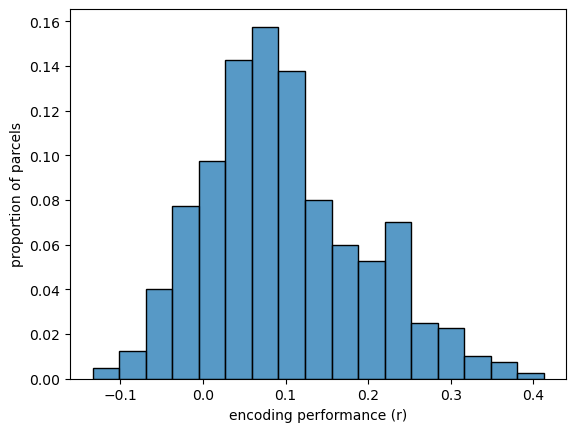

In [22]:
from himalaya.scoring import correlation_score

# Evaluate predictions: correlation between predicted and actual time series
score_parcels = correlation_score(Y_parcels, Y_predicted)

print(f"Mean encoding performance: r = {np.mean(score_parcels):.3f}")
print(f"Maximum encoding performance: r = {np.amax(score_parcels):.3f}")

# Plot a histogram of prediction performance values
fig, ax = plt.subplots()
sns.histplot(score_parcels, stat='proportion', ax=ax)
ax.set(xlabel='encoding performance (r)', ylabel='proportion of parcels');

We can also certain attributes of our fitted encoding model. For example, we may want to examine, the best alpha values selected from hyperparameter search, or we may want to recover the weight vectors estimated for a given training set.

In [23]:
# Introspect fitted pipeline model for alphas and weights
ridge_fitted = pipeline['kernelridgecv']
best_alphas = ridge_fitted.best_alphas_
weights = ridge_fitted.get_primal_coef(ridge_fitted.X_fit_)

In [24]:
# take sample text from the training data
# use gpt2 to tokenize
# use beam search to generate 5 continuations
# use encoding model to predict bold activity for each continuation
# rank predictions based on similarity to true bold data

In [25]:
transcript_gpt2.head()

,word_index,word,onset,offset,token,token_id,rank,true_prob,top_pred,entropy,embedding,TR
0,0,So,0.24,0.63,ĠSo,1406,NaN,NaN,<|endoftext|>,NaN,"[1.0905523, -0.17343742, 0.9175235, 0.17447776...",0
1,1,I,0.68,1.26,ĠI,314,6.0,0.017341,",",7.148897,"[0.50179887, -2.0902424, 3.5390313, 0.30429807...",0
2,2,was,1.96,2.30,Ġwas,373,3.0,0.039637,'m,4.817326,"[-1.1007986, -0.70251, 0.9658945, 0.047611117,...",1
3,3,a,2.30,2.45,Ġa,257,5.0,0.022551,Ġjust,5.935085,"[-1.3298147, 0.8528729, 2.9786375, -5.106433, ...",1
4,4,junior,2.46,3.14,Ġjunior,13430,53.0,0.001607,Ġlittle,5.770843,"[4.4429407, 2.79686, -5.1273913, -1.6790004, 4...",1


In [26]:
# "sample" means the input text that we use as the starting point for prediction
tr_start = 0  # TR to start the sample at
n_trs_to_sample = 3  # duration (in TRs) of the sample
n_trs_to_test = 3  # how much further (in TRs) past the sample do you want to predict?

sample_idx = transcript_gpt2[transcript_gpt2['TR'] >= tr_start][transcript_gpt2['TR'] <= tr_start+n_trs_to_sample].index  # token indices corresponding to sample
test_idx = transcript_gpt2[transcript_gpt2['TR'] >= tr_start][transcript_gpt2['TR'] <= tr_start+n_trs_to_sample+n_trs_to_test].index  # token indices corresponding to test
new_token_idx = [x for x in test_idx if x not in sample_idx]  # the token indices that are in the test but not the sample

sample_text = " ".join(list(transcript_gpt2['word'][sample_idx.min():sample_idx.max()]))
ground_truth = " ".join(list(transcript_gpt2['word'][test_idx.min():test_idx.max()]))

inputs = tokenizer(sample_text, return_tensors="pt").to(device)

# Generate continuations using nucleus sampling (https://huggingface.co/blog/how-to-generate)
beam_outputs = model.generate(**inputs,
                              num_return_sequences=5,
                              max_new_tokens=len(new_token_idx),  # cheating because we know the number of tokens we want to predict (would be replaced by word rate model)
                              do_sample=True,
                              top_p=0.92,
                              top_k=20,
                              temperature=1.0)

# Decode the generated sequences
generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in beam_outputs]

all_pred_bold = []
for text in generated_texts:
    # 1. Tokenize the generated text:
    tokenized_text = tokenizer.encode(text, return_tensors="pt").to(device)

    # 2. Get embeddings from GPT-2:
    with torch.no_grad():
        output = model(tokenized_text, output_hidden_states=True)
        embeddings = output.hidden_states[8][0].cpu().numpy()  # Assuming layer 8, adjust if necessary.
        # print(embeddings.shape)

    # 3. Predict BOLD activity using fitted encoding model
    delay = 0
    predicted_bold = embeddings @ weights[768*delay:768*(delay+1)]  # weights have 4 delay options
    all_pred_bold.append(predicted_bold)

# Rank predictions based on similarity to true BOLD data
from scipy.stats import pearsonr

# index pred_bold at new tokens only; index Y_parcels at new TRs only
similarities = [pearsonr(pred_bold[-1*len(new_token_idx):].mean(axis=0), Y_parcels[tr_start+n_trs_to_sample:tr_start+n_trs_to_sample+n_trs_to_test].mean(axis=0))[0] for pred_bold in all_pred_bold]

sorted_indices = np.argsort(similarities)[::-1] # [::-1] reverses a list so it's in descending order of similarity

print('Input: ', sample_text)
print('True continuation:', '\n', ground_truth, '\n')

# Print ranked continuations and their similarities
for i, idx in enumerate(sorted_indices):
    print(f"Rank #{i+1}, candidate #{idx+1}, similarity={similarities[idx]:.4f}:")
    print(generated_texts[idx] + '\n')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Input:  So I was a junior in college when I got my
True continuation: 
 So I was a junior in college when I got my first paying in my field 

Rank #1, candidate #2, similarity=0.4572:
 So I was a junior in college when I got my first job in the company

Rank #2, candidate #5, similarity=0.3759:
 So I was a junior in college when I got my first chance to try this

Rank #3, candidate #3, similarity=0.3746:
 So I was a junior in college when I got my first call about the game

Rank #4, candidate #4, similarity=0.3085:
 So I was a junior in college when I got my start. I went to

Rank #5, candidate #1, similarity=0.3047:
 So I was a junior in college when I got my first guitar. When I



In [27]:
num_candidates = 3

# "sample" means the input text that we use as the starting point for prediction
tr_start = 0  # TR to start the sample at
n_trs_to_sample = 3  # duration (in TRs) of the sample
n_trs_to_test = 3  # how much further (in TRs) past the sample do you want to predict?

sample_idx = transcript_gpt2[transcript_gpt2['TR'] >= tr_start][transcript_gpt2['TR'] <= tr_start+n_trs_to_sample].index  # token indices corresponding to sample
test_idx = transcript_gpt2[transcript_gpt2['TR'] >= tr_start][transcript_gpt2['TR'] <= tr_start+n_trs_to_sample+n_trs_to_test].index  # token indices corresponding to test
new_token_idx = [x for x in test_idx if x not in sample_idx]  # the token indices that are in the test but not the sample

sample_text = " ".join(list(transcript_gpt2['word'][sample_idx.min():sample_idx.max()]))
ground_truth = " ".join(list(transcript_gpt2['word'][test_idx.min():test_idx.max()]))

inputs = tokenizer(sample_text, return_tensors="pt").to(device)
try:
  del sorted_generations
except:
    pass

for i in range(num_candidates):
  print('\n', 'Iteration', i)
  try:
    inputs = tokenizer(sorted_generations[i], return_tensors="pt").to(device)
    print('updating inputs')
    # breakpoint()
  except:
    pass
  # Generate continuations using nucleus sampling (https://huggingface.co/blog/how-to-generate)
  print(inputs)
  beam_outputs = model.generate(**inputs,
                                num_return_sequences=num_candidates,
                                max_new_tokens=len(new_token_idx),  # cheating because we know the number of tokens we want to predict (would be replaced by word rate model)
                                do_sample=True,
                                top_p=0.92,
                                top_k=20,
                                temperature=1.0,
                                pad_token_id=50256)

  # Decode the generated sequences
  generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in beam_outputs]

  all_pred_bold = []
  for text in generated_texts:
      # 1. Tokenize the generated text:
      tokenized_text = tokenizer.encode(text, return_tensors="pt").to(device)

      # 2. Get embeddings from GPT-2:
      with torch.no_grad():
          output = model(tokenized_text, output_hidden_states=True)
          embeddings = output.hidden_states[8][0].cpu().numpy()  # layer 8
          # print(embeddings.shape)

      # 3. Predict BOLD activity using fitted encoding model
      delay = 0
      predicted_bold = embeddings @ weights[768*delay:768*(delay+1)]  # weights have 4 delay options
      all_pred_bold.append(predicted_bold)

  # Rank predictions based on similarity to true BOLD data
  from scipy.stats import pearsonr

  # index pred_bold at new tokens only; index Y_parcels at new TRs only
  similarities = [pearsonr(pred_bold[-1*len(new_token_idx):].mean(axis=0),
                           Y_parcels[tr_start+n_trs_to_sample:tr_start+n_trs_to_sample+n_trs_to_test].mean(axis=0))[0]
                  for pred_bold in all_pred_bold]

  sorted_indices = np.argsort(similarities)[::-1] # [::-1] reverses a list so it's in descending order of similarity

  print('Input: ', tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
  # print('True continuation:', '\n', ground_truth, '\n')

  # Print ranked continuations and their similarities
  for i, idx in enumerate(sorted_indices):
      print(f"Rank #{i+1}, candidate #{idx+1}, similarity={similarities[idx]:.4f}:")
      print(generated_texts[idx] + '\n')

  sorted_generations = [generated_texts[i] for i in sorted_indices]
  # print(len(sorted_generations))
  # if len(sorted_generations) > num_candidates*5:
  #     sorted_generations = sorted_generations[:num_candidates*5]  # prune the candidates post-sorting to prevent the number from growing too fast



 Iteration 0
{'input_ids': tensor([[ 1406,   314,   373,   257, 13430,   287,  4152,   618,   314,  1392,
           616]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Input:   So I was a junior in college when I got my
Rank #1, candidate #2, similarity=0.4230:
 So I was a junior in college when I got my first shot to be a

Rank #2, candidate #1, similarity=0.4075:
 So I was a junior in college when I got my bachelor's degree. I

Rank #3, candidate #3, similarity=0.3431:
 So I was a junior in college when I got my first tattoo of my brother


 Iteration 1
updating inputs
{'input_ids': tensor([[ 1406,   314,   373,   257, 13430,   287,  4152,   618,   314,  1392,
           616, 29384,   338,  4922,    13,   314]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Input:   So I was a junior in college when I got my bachelor's degree. I
Rank #1, candidate #1, similarity=0.3545:
 So I was a junior in college when I got my bachelor's degree

In [ ]:
num_candidates = 3

# "sample" means the input text that we use as the starting point for prediction
tr_start = 0  # TR to start the sample at
n_trs_to_sample = 3  # duration (in TRs) of the sample
n_trs_to_test = 3  # how much further (in TRs) past the sample do you want to predict?
max_depth = 3

sample_idx = transcript_gpt2[transcript_gpt2['TR'] >= tr_start][transcript_gpt2['TR'] <= tr_start+n_trs_to_sample].index  # token indices corresponding to sample
test_idx = transcript_gpt2[transcript_gpt2['TR'] >= tr_start][transcript_gpt2['TR'] <= tr_start+n_trs_to_sample+n_trs_to_test].index  # token indices corresponding to test
new_token_idx = [x for x in test_idx if x not in sample_idx]  # the token indices that are in the test but not the sample

sample_text = " ".join(list(transcript_gpt2['word'][sample_idx.min():sample_idx.max()]))
ground_truth = " ".join(list(transcript_gpt2['word'][test_idx.min():test_idx.max()]))

inputs = tokenizer(sample_text, return_tensors="pt").to(device)
try:
  del sorted_generations
except:
    pass

for depth in range(max_depth):
  next_inputs = []
  print(next_inputs)
  for i in range(num_candidates):
    print('\n', 'Iteration', i)
    try:
      inputs = tokenizer(sorted_generations[i], return_tensors="pt").to(device)
      print('updating inputs')
      # breakpoint()
    except:
      pass

    # Generate continuations using nucleus sampling (https://huggingface.co/blog/how-to-generate)
    beam_outputs = model.generate(**inputs,
                                  num_return_sequences=num_candidates,
                                  max_new_tokens=len(new_token_idx),  # cheating because we know the number of tokens we want to predict (would be replaced by word rate model)
                                  do_sample=True,
                                  top_p=0.92,
                                  top_k=20,
                                  temperature=1.0,
                                  pad_token_id=50256)

    # Decode the generated sequences
    generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in beam_outputs]

    all_pred_bold = []
    for text in generated_texts:
        # 1. Tokenize the generated text:
        tokenized_text = tokenizer.encode(text, return_tensors="pt").to(device)

        # 2. Get embeddings from GPT-2:
        with torch.no_grad():
            output = model(tokenized_text, output_hidden_states=True)
            embeddings = output.hidden_states[8][0].cpu().numpy()  # layer 8
            # print(embeddings.shape)

        # 3. Predict BOLD activity using fitted encoding model
        delay = 0
        predicted_bold = embeddings @ weights[768*delay:768*(delay+1)]  # weights have 4 delay options
        all_pred_bold.append(predicted_bold)

    # Rank predictions based on similarity to true BOLD data
    from scipy.stats import pearsonr

    # index pred_bold at new tokens only; index Y_parcels at new TRs only
    similarities = [pearsonr(pred_bold[-1*len(new_token_idx):].mean(axis=0),
                            Y_parcels[tr_start+n_trs_to_sample:tr_start+n_trs_to_sample+n_trs_to_test].mean(axis=0))[0]
                    for pred_bold in all_pred_bold]

    sorted_indices = np.argsort(similarities)[::-1] # [::-1] reverses a list so it's in descending order of similarity

    # print('Input: ', tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
    # print('True continuation:', '\n', ground_truth, '\n')

    # Print ranked continuations and their similarities
    # for s, idx in enumerate(sorted_indices):
    #     print(f"Rank #{s+1}, candidate #{idx+1}, similarity={similarities[idx]:.4f}:")
    #     print(generated_texts[idx] + '\n')

    sorted_generations = [generated_texts[i] for i in sorted_indices]
    # print(sorted_generations)

  next_inputs.append(sorted_generations)
  print(next_inputs)
  inputs = next_inputs

    # print(sorted_generations)
    # print(len(sorted_generations))
    # if len(sorted_generations) > num_candidates*5:
    #     sorted_generations = sorted_generations[:num_candidates*5]  # prune the candidates post-sorting to prevent the number from growing too fast


[]

 Iteration 0

 Iteration 1
updating inputs

 Iteration 2
updating inputs
[[' So I was a junior in college when I got my first copy of Harry Potter.\n\nThere was no one else who knew', ' So I was a junior in college when I got my first copy of Harry Potter.\n\nThere was no magic involved. I', ' So I was a junior in college when I got my first copy of Harry Potter.\n\nThere was so much to see there']]
[]

 Iteration 0
updating inputs

 Iteration 1
updating inputs

 Iteration 2
updating inputs
[[' So I was a junior in college when I got my first copy of Harry Potter.\n\nThere was no one else who knew about the books. I read every book in the school library and was hooked', ' So I was a junior in college when I got my first copy of Harry Potter.\n\nThere was no one else who knew about the books. I read every book in the library.\n\nMy', ' So I was a junior in college when I got my first copy of Harry Potter.\n\nThere was no one else who knew about the books. I read every book in the se

In [ ]:
tokenizer.decode(inputs['input_ids'][0])

' So I was a junior in college when I got my'

In [ ]:
num_candidates = 3
max_depth = 3

tr_start = 0
n_trs_to_sample = 3
n_trs_to_test = 3

sample_idx = transcript_gpt2[transcript_gpt2['TR'] >= tr_start][transcript_gpt2['TR'] <= tr_start+n_trs_to_sample].index
test_idx = transcript_gpt2[transcript_gpt2['TR'] >= tr_start][transcript_gpt2['TR'] <= tr_start+n_trs_to_sample+n_trs_to_test].index
new_token_idx = [x for x in test_idx if x not in sample_idx]

sample_text = " ".join(list(transcript_gpt2['word'][sample_idx.min():sample_idx.max()]))
ground_truth = " ".join(list(transcript_gpt2['word'][test_idx.min():test_idx.max()]))

# Initialize with first input
current_inputs = [{'text': sample_text, 'depth': 0, 'branch_id': '0'}]

# Loop through depths
for depth in range(max_depth):
    next_inputs = []  # Will store inputs for next depth level

    # Process each input at current depth
    for input_idx, current_input in enumerate(current_inputs):
        print(f"\n{'='*80}")
        print(f"DEPTH {depth}, BRANCH {current_input['branch_id']}")
        print(f"INPUT: {current_input['text']}")
        print(f"{'='*80}")

        # Tokenize current input
        inputs = tokenizer(current_input['text'], return_tensors="pt").to(device)

        # Generate continuations
        beam_outputs = model.generate(**inputs,
                                    num_return_sequences=num_candidates,
                                    max_new_tokens=len(new_token_idx),
                                    do_sample=True,
                                    top_p=0.92,
                                    top_k=20,
                                    temperature=1.0,
                                    pad_token_id=50256)

        # Decode the generated sequences
        generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in beam_outputs]

        # Score generations
        all_pred_bold = []
        for text in generated_texts:
            tokenized_text = tokenizer.encode(text, return_tensors="pt").to(device)

            with torch.no_grad():
                output = model(tokenized_text, output_hidden_states=True)
                embeddings = output.hidden_states[8][0].cpu().numpy()

            delay = 0
            predicted_bold = embeddings @ weights[768*delay:768*(delay+1)]
            all_pred_bold.append(predicted_bold)

        # Calculate similarities
        similarities = [pearsonr(pred_bold[-1*len(new_token_idx):].mean(axis=0),
                               Y_parcels[tr_start+n_trs_to_sample:tr_start+n_trs_to_sample+n_trs_to_test].mean(axis=0))[0]
                      for pred_bold in all_pred_bold]

        # Print all candidates for this branch
        print(f"\nCANDIDATES FOR BRANCH {current_input['branch_id']}:")
        for i, (text, similarity) in enumerate(zip(generated_texts, similarities)):
            print(f"\nCandidate {i+1}, Similarity: {similarity:.4f}")
            print(f"Text: {text}")

        # Sort generations by similarity
        sorted_indices = np.argsort(similarities)[::-1]
        sorted_generations = [generated_texts[i] for i in sorted_indices]
        sorted_similarities = [similarities[i] for i in sorted_indices]

        # Add top candidates as inputs for next depth
        for i, (gen, sim) in enumerate(zip(sorted_generations[:num_candidates],
                                         sorted_similarities[:num_candidates])):
            new_branch_id = f"{current_input['branch_id']}.{i}"
            next_inputs.append({
                'text': gen,
                'depth': depth + 1,
                'branch_id': new_branch_id,
                'similarity': sim
            })

            print(f"\nSelected for next depth - Branch {new_branch_id}")
            print(f"Similarity: {sim:.4f}")
            print(f"Text: {gen}")

    # Update current_inputs for next depth
    current_inputs = next_inputs

    print(f"\n{'#'*80}")
    print(f"COMPLETED DEPTH {depth}")
    print(f"Number of branches for next depth: {len(current_inputs)}")
    print(f"{'#'*80}")

print("\nGeneration Complete!")



DEPTH 0, BRANCH 0
INPUT: So I was a junior in college when I got my

CANDIDATES FOR BRANCH 0:

Candidate 1, Similarity: 0.4248
Text:  So I was a junior in college when I got my first shot at playing a

Candidate 2, Similarity: 0.3965
Text:  So I was a junior in college when I got my first job, and we

Candidate 3, Similarity: 0.3932
Text:  So I was a junior in college when I got my first call at age 10

Selected for next depth - Branch 0.0
Similarity: 0.4248
Text:  So I was a junior in college when I got my first shot at playing a

Selected for next depth - Branch 0.1
Similarity: 0.3965
Text:  So I was a junior in college when I got my first job, and we

Selected for next depth - Branch 0.2
Similarity: 0.3932
Text:  So I was a junior in college when I got my first call at age 10

################################################################################
COMPLETED DEPTH 0
Number of branches for next depth: 3
########################################################################

In [ ]:
pred_bold[-1*len(new_token_idx):].mean(axis=0).shape

(400,)

In [ ]:
# what text data am i using?
sample_text = " ".join(list(transcript_gpt2['word'][input_start : input_start+n_sample_tokens]))

# what are the corresponding TRs for the input data?
transcript_gpt2[transcript_gpt2['TR'] <= 7]

,word_index,word,onset,offset,token,token_id,rank,true_prob,top_pred,entropy,embedding,TR
0,0,So,0.240000,0.630000,ĠSo,1406,NaN,NaN,<|endoftext|>,NaN,"[1.0905547, -0.17344014, 0.91752285, 0.1744757...",0
1,1,I,0.680000,1.260000,ĠI,314,6.0,0.017341,",",7.148902,"[0.5017998, -2.0902424, 3.5390282, 0.30429798,...",0
2,2,was,1.960000,2.300000,Ġwas,373,3.0,0.039634,'m,4.817344,"[-1.1007988, -0.7025111, 0.96589136, 0.0476092...",1
3,3,a,2.300000,2.450000,Ġa,257,5.0,0.022548,Ġjust,5.935095,"[-1.329814, 0.8528788, 2.9786367, -5.1064243, ...",1
4,4,junior,2.460000,3.140000,Ġjunior,13430,53.0,0.001607,Ġlittle,5.770852,"[4.4429436, 2.796859, -5.1273956, -1.6790009, ...",1
5,5,in,3.140000,3.410000,Ġin,287,1.0,0.165316,Ġat,4.166420,"[3.6545837, -2.2084537, -0.3126945, -1.4611255...",2
6,6,college,3.410000,4.200000,Ġcollege,4152,1.0,0.154319,Ġhigh,1.320331,"[1.9245641, -0.4866644, -3.7626815, 1.6225989,...",2
7,7,when,4.790000,5.020000,Ġwhen,618,3.0,0.071544,Ġand,2.541404,"[1.2996331, -0.6207447, -0.16586041, 0.8665891...",3
8,8,I,5.020000,5.090000,ĠI,314,0.0,0.403896,ĠI,3.931901,"[0.8777293, -1.5289568, 2.099099, -1.530497, -...",3
9,9,got,5.090000,5.330000,Ġgot,1392,1.0,0.079014,Ġwas,4.176659,"[-2.048574, -6.086743, 2.702452, -4.5428843, 0...",3


In [ ]:
transcript_gpt2.TR.max()

533

For illustrative purposes, we'll plot the actual and predicted time series for an example parcel. Finally, we'll use the `masker`'s `.inverse_transform()` method to convert the parcel-level correlation scores back to into a brain image for visualization.

In [ ]:
# Plot predicted and actual response for example parcel:
example_parcel = 195
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(zscore(Y_parcels[:, example_parcel]), label='actual')
ax.plot(zscore(Y_predicted[:, example_parcel]), label='predicted')
ax.annotate(f'$\it{{r}}$ = {score_parcels[example_parcel]:.3f}',
            xy=(10, 10), xycoords='axes points', fontsize=12)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, Y_predicted.shape[0]))
ax.legend()
sns.despine()

In [ ]:
# Invert masker transform to project onto brain
score_img = masker.inverse_transform(score_parcels)

# Plot encoding performance correlations on brain
vmax = .4
threshold = .1
plot_stat_map(score_img, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(-55, -24, 9))

# Plot correlations to visualize posterior medial cortex
plot_stat_map(score_img, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(5, -60, 33));

In [ ]:
from surfplot.utils import threshold

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(score_img, method='nearest')

# Threshold at an arbitrary correlation value
gii_lh = threshold(gii_lh.agg_data(), .1)
gii_rh = threshold(gii_rh.agg_data(), .1)

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='RdYlBu_r', color_range=(-.4, .4))
cbar_kws = dict(location='right', draw_border=False, aspect=10,
                shrink=.2, decimals=1, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)

### Banded ridge regression
In the previous section, we fit separate models for the word2vec and GPT-2 embeddings. However, these embeddings likely encode a lot of similar information, making it difficult to compare the feature spaces. One way to compare feature spaces is to fit both feature spaces jointly, allowing them both to vie for variance in the brain activity—then evaluate their predictions separately. Our first thought might be to horizontally stack the word2vec and GPT-2 features, then refit the model in the same as the previous section. The problem with this approach is that our encoding model will find a single hyperparameter for both feature spaces. If the feature spaces are qualitatively different from each other, the hyperparameter will likely be unfairly biased toward one feature space. For example, if one feature space is very high-dimensional (i.e. wide) and the other is not, the fitting procedure will likely find a strong penalty term to regularize the wide predictors—but this hyperparameter may overly "squeeze" the lower-dimensional predictors. To solve this problem, we'll use `himalaya`'s implementation of *banded ridge regression* to estimate a separate regularization parameter for each feature space (i.e. band) in the joint predictor matrix ([Nunez-Elizalde et al., 2019](https://doi.org/10.1016/j.neuroimage.2019.04.012); [Dupré la Tour et al., 2022](https://doi.org/10.1016/j.neuroimage.2022.119728)). The first step is to horizontally-stack our predictors for both feature space; we'll use `slice`s to keep track of which columns belong to which feature space.

In [ ]:
# Horizontal-stack both embeddings to create joint model
X_joint = np.hstack([X_w2v, X_gpt2])
print(f"Joint predictor matrix shape: {X_joint.shape}")

width_w2v = X_w2v.shape[1]
width_gpt2 = X_gpt2.shape[1]

slice_w2v = slice(0, width_w2v)
slice_gpt2 = slice(width_w2v, width_w2v + width_gpt2)
print(f"word2vec slice: {slice_w2v}")
print(f"GPT-2 slice: {slice_gpt2}")

We'll set up the usual cross-validation scheme here. We need to take special care to apply the usual transforms—especially the kernelization step—to each set of predictors separately. We'll build a pipeline containing the necessary transforms, then use `himalaya`'s `ColumnKernelizer` apply this pipeline separately to both sets of predictors according to the `slice`s we defined.

In [ ]:
from himalaya.kernel_ridge import Kernelizer, ColumnKernelizer

# Split-half outer and inner cross-validation
outer_cv = KFold(n_splits=2)
inner_cv = KFold(n_splits=5)

# Make pipeline with kernelizer for each feature space
column_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    Delayer(delays=[2, 3, 4, 5]),
    Kernelizer(kernel="linear"),
)

# Compile joint column kernelizer
column_kernelizer = ColumnKernelizer(
    [('word2vec', column_pipeline, slice_w2v),
     ('gpt2', column_pipeline, slice_gpt2)])

We'll use `MultipleKernelRidgeCV` to implement banded ridge regression with hyperparameter search. Since banded ridge regression applies separate penalty terms to each feature space, we need to search over combinations of hyperparameters. This can become very computationally expensive, so we'll use random search to find a good combination of regularization parameters. We initialize the model and link it up to our `ColumnKernelizer` pipeline.

In [ ]:
from himalaya.kernel_ridge import MultipleKernelRidgeCV

# Ridge regression with alpha grid and nested CV
solver = 'random_search'
n_iter = 20
alphas = np.logspace(1, 10, 10)
solver_params = dict(n_iter=n_iter, alphas=alphas)

# Banded ridge regression with column kernelizer
banded_ridge = MultipleKernelRidgeCV(kernels="precomputed", solver=solver,
                                     solver_params=solver_params, cv=inner_cv)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(column_kernelizer, banded_ridge)

First, similarly to the previous exercise, we'll fit the joint model, generate a single set of predictions based on the combined feature spaces, and evaluate the quality of these predictions by computing the correlation between actual and predicted time series. This gives us an overall idea of how well the joint model predicts brain activity. In this approach, each set of predictors receives it's own regularization parameter, which should provide a better overall fit than if we had naively combined both sets of predictors under a single regularization parameter. Below, we compute the socres and visualize the results—but this isn't the end of the story! In the next section, we use banded ridge regression to compare feature spaces...

In [ ]:
# Loop through outer folds and estimate model
Y_predicted = []
for train, test in outer_cv.split(Y_parcels):

    # Fit pipeline with transforms and ridge estimator
    pipeline.fit(X_joint[train],
                 Y_parcels[train])

    # Compute predicted response
    predicted = pipeline.predict(X_joint[test])
    Y_predicted.append(predicted)

# Restack first and second half predictions
Y_predicted = np.vstack(Y_predicted)

In [ ]:
from himalaya.scoring import correlation_score

# Evaluate predictions: correlation between predicted and actual time series
score_parcels = correlation_score(Y_predicted, Y_parcels)

print(f"Mean encoding performance: r = {np.mean(score_parcels):.3f}")
print(f"Maximum encoding performance: r = {np.amax(score_parcels):.3f}")

# Plot a histogram of prediction performance values
fig, ax = plt.subplots()
sns.histplot(score_parcels, stat='proportion', ax=ax)
ax.set(xlabel='encoding performance (r)', ylabel='proportion of parcels');

In [ ]:
# Invert masker transform to project onto brain
score_img = masker.inverse_transform(score_parcels)

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(score_img, method='nearest')

# Threshold at an arbitrary correlation value
gii_lh = threshold(gii_lh.agg_data(), .1)
gii_rh = threshold(gii_rh.agg_data(), .1)

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='RdYlBu_r', color_range=(-.4, .4))
cbar_kws = dict(location='right', draw_border=False, aspect=10,
                shrink=.2, decimals=1, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)

### Comparing feature spaces
Previously we estimated the joint model containing both word2vec and GPT-2 embeddings and evaluated the performance of the combined feature spaces. However, the more important question is typically: How do these feature spaces compare to one another? Here, we fit the joint model in the same way as the previous section—but critically we generate predictions separately for each feature space (using `split=True` in the `.predict()` method of the pipeline culminating in `MultipleKernelRidgeCV`). Remember that we generate model-based predictions by multiplying the weight vector estimated from the training set with the predictors from the test set. In this approach, we effectively zero-out weights for the feature-space(s)-of-no-interest to quantify how much one feature space contributes to performance.

In [ ]:
# Loop through outer folds and estimate model
Y_predicted = []
for train, test in outer_cv.split(Y_parcels):

    # Fit pipeline with transforms and ridge estimator
    pipeline.fit(X_joint[train],
                 Y_parcels[train])

    # Compute predicted response
    predicted = pipeline.predict(X_joint[test], split=True)
    Y_predicted.append(predicted)

# Restack first and second half predictions
Y_predicted = np.concatenate(Y_predicted, axis=1)

We can use `himalaya`'s `correlation_score_split` to easily compute correlation scores for the predictions based on each feature space.

In [ ]:
from himalaya.scoring import correlation_score_split

# Compute correlation between predicted and actual for split predictions
score_w2v, score_gpt2 = correlation_score_split(Y_parcels, Y_predicted)

Let's summarize and compare the performance of both feature spaces using both a histogram and brain maps. What do you observe?

In [ ]:
print(f"Mean word2vec encoding performance: r = {np.mean(score_w2v):.3f}")
print(f"Maximum word2vec encoding performance: r = {np.amax(score_w2v):.3f}")

print(f"Mean GPT-2 encoding performance: r = {np.mean(score_gpt2):.3f}")
print(f"Maximum GPT-2 encoding performance: r = {np.amax(score_gpt2):.3f}")

# Plot a histogram of prediction performance values
score_df = pd.DataFrame({'feature space': np.repeat(['word2vec', 'GPT-2'], n_parcels),
                         'encoding performance (r)': np.hstack([score_w2v, score_gpt2])})
fig, ax = plt.subplots()
sns.histplot(score_df, x='encoding performance (r)', hue='feature space',
             stat='proportion', ax=ax)
ax.set(xlabel='encoding performance (r)', ylabel='proportion of parcels');

In [ ]:
# Invert masker transform to project onto brain
score_img = masker.inverse_transform(score_w2v)

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(score_img, method='nearest')

# Threshold at an arbitrary correlation value
gii_lh = threshold(gii_lh.agg_data(), .1)
gii_rh = threshold(gii_rh.agg_data(), .1)

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='RdYlBu_r', color_range=(-.4, .4))
cbar_kws = dict(location='right', draw_border=False, aspect=10,
                shrink=.2, decimals=1, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)

In [ ]:
# Invert masker transform to project onto brain
score_img = masker.inverse_transform(score_gpt2)

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(score_img, method='nearest')

# Threshold at an arbitrary correlation value
gii_lh = threshold(gii_lh.agg_data(), .1)
gii_rh = threshold(gii_rh.agg_data(), .1)

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='RdYlBu_r', color_range=(-.4, .4))
cbar_kws = dict(location='right', draw_border=False, aspect=10,
                shrink=.2, decimals=1, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)

## Natural language comprehension ECoG dataset
In our second example, we'll use electrocorticography (ECoG) data acquired in an epilepsy patient listening to a 30-minute podcast episode called "[Monkey in the Middle](https://www.thisamericanlife.org/631/so-a-monkey-and-a-horse-walk-into-a-bar/act-one-0)" from the *This American Life* podcast ([Goldstein et al., 2022](https://doi.org/10.1038/s41593-022-01026-4)). This dataset has been preprocessed use [MNE](https://mne.tools/stable/index.html): common-average referencing, notch filtering for line noise, bandpass filtered for high gamma (70–200 Hz). We begin by loading in the preprocessed data using MNE. For the sake of expedience, we'll estimate encoding models based on only the word2vec embeddings—but this example should be easily extensible to the more complex procedure described in the previous section. First, we'll load in the ECoG data and visualize the electrode locations.

In [ ]:
import mne

# Load data into MNE "Raw" object
raw = mne.io.read_raw('sub-717_task-monkey_desc-clean_ieeg.fif')

In [ ]:
from nilearn.plotting import plot_markers

# Plot the electrode coordinates
node_coords = np.vstack([ch['loc'][:3] for ch in raw.info['chs']])
node_values = np.ones(len(node_coords))
plot_markers(node_values, node_coords,
             node_vmin=0, node_vmax=1.5,
             node_size=50, node_cmap='Blues',
             display_mode='lyr', colorbar=False);

Now, we'll load in the transcript and assign word2vec embeddings to each word.

In [ ]:
# Download 300-dimensional word2vec embeddings
model_name = 'word2vec-google-news-300'
model = gensim.downloader.load(model_name)

# Load in transcript CSV file
transcript_f = 'monkey_transcript.csv'
transcript_w2v = pd.read_csv(transcript_f)

# Convert words to lowercase
transcript_w2v['word'] = transcript_w2v.word.str.lower()

# Function to extract embeddings if available
def get_vector(word):
    if word in model.key_to_index:
        return model.get_vector(word, norm=True).astype(np.float32)
    return np.nan

# Extract embedding for each word
transcript_w2v['embedding'] = transcript_w2v.word.apply(get_vector)
transcript_w2v = transcript_w2v.astype({'onset': 'float32', 'offset': 'float32'}, copy=False)

# Print out words not found in vocabulary
print(f'{(transcript_w2v.embedding.isna()).sum()} words not found:')
print(transcript_w2v.word[transcript_w2v.embedding.isna()].value_counts())

# Save transcript with embeddings using pickle
with open('monkey_w2v.pkl', 'wb') as f:
    pickle.dump(transcript_w2v, f)

In [ ]:
# Clear gensim word2vec model out of memory to save RAM
del model

# Reload transcript with embeddings if already generated
transcript_f = 'monkey_w2v.pkl'
if exists(transcript_f):
    with open(transcript_f, 'rb') as f:
        transcript_w2v = pickle.load(f)

MNE allows us to assign word stimuli, as well as their onsets and durations, directly to the `Raw` object. (Note that MNE treats annotations containing the word "bad" in a special way.)

In [ ]:
# Add word onsets as annotations to the raw object
annotations = mne.Annotations(transcript_w2v.onset.to_numpy() / 512,
                              (transcript_w2v.offset - transcript_w2v.onset).to_numpy() / 512,
                              description=transcript_w2v.word.to_numpy())
raw = raw.set_annotations(annotations)

In [ ]:
# Extract word onsets from the annotations
events, event_id = mne.events_from_annotations(raw, regexp=None, verbose=False)
word_ids = {word: id for id, word in event_id.items()}
words = [word_ids[word_id] for word_id in events[:, 2]]
print(f'First few words: "{" ".join(words[:9])}"')

We'll take advantage of MNE's tools for creating epochs around stimulus events to first visualize electrodes that respond to word onsets. We effectively extract fixed-width windows around each word onset, then average each electrode's signal across all words, yielding event-related potentials (ERPs) for word onset.

In [ ]:
# Convert events to epochs
epochs = mne.Epochs(raw,
                    events, event_id=event_id,
                    event_repeated='drop',
                    tmin=-0.5, tmax=1.0,
                    picks='ecog',
                    detrend=None,
                    baseline=(None, 0),
                    reject_by_annotation=False)
epochs = epochs.load_data()

We'll focus in on handful of "good" electrodes with obvious ERPs for the purpose of visualization.

In [ ]:
# Plot average response for one good electrode
good_erp = [9, 36, 37, 38, 45, 46]
example_electrode = 9

epochs.plot_image(picks=[example_electrode]);

In [ ]:
# Average epochs for evoked response across good electrodes
evoked = epochs.average(picks=good_erp)
evoked.plot();

Now that we've convinced ourselves there's some word-related signal in the ECoG data, let's get back to the word embeddings. We'll compile our embeddings into a predictor matrix `X` and ensure that these embeddings match the ECoG epochs.

In [ ]:
# Compile embeddings from transcript
words_keep = np.where(transcript_w2v['embedding'].notna())[0]
X_w2v = np.vstack(transcript_w2v['embedding'][words_keep])

# Only include events where we have word embeddings
events = events[words_keep]

We'll recreate our epochs around each word with a wider window and minimal processing. We'll downsample the temporal resolution to 100 Hz; that is, 100 samples per second. For a window ranging from -2 seconds to +2 seconds relative to word onset, we should have 400 lags.

In [ ]:
# Recreate epochs without any processing (e.g., baseline correction)
epochs = mne.Epochs(raw,
                    events, event_repeated='drop',
                    tmin=-2.0, tmax=2.0,
                    picks='ecog',
                    reject_by_annotation=None,
                    detrend=None,
                    baseline=None)
epochs = epochs.load_data()

# Resample here so we don't have so many lags
epochs = epochs.resample(100)

# Extract data from epochs object
Y_lags = epochs._data
print(f"ECoG data matrix shape: {Y_lags.shape}")

We plan to fit encoding models at each electrode and for each lag, so we'll reshape our target matrix `Y` to horizontally stack both electrodes and lags along the second dimension.

In [ ]:
# Get target matrix shape
n_words, n_electrodes, n_lags = Y_lags.shape

Y_lags = Y_lags.reshape(n_words, n_electrodes * n_lags)
print(f"ECoG data matrix shape: {Y_lags.shape}")

Finally, we'll use ridge regression to estimate the encoding model similarly to before. Here, don't need to duplicate predictor matrix at multiple lags due to the high temporal resolution of ECoG data acquisition. In this case, we have many more samples than the width of the word2vec model—so we use `RidgeCV` rather than `KernelRidgeCV`. To close, we fit the model, generate predictions, and visualize the results.

In [ ]:
from himalaya.ridge import RidgeCV

# Split-half outer and inner cross-validation
outer_cv = KFold(n_splits=2, shuffle=False)
inner_cv = KFold(n_splits=5, shuffle=False)

# Ridge regression with alpha grid and nested CV
alphas = np.logspace(1, 10, 10)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    RidgeCV(alphas=alphas, cv=inner_cv))

In [ ]:
# Loop through outer folds and estimate model
Y_predicted = []
for train, test in outer_cv.split(Y_lags):

    # Fit pipeline with transforms and ridge estimator
    pipeline.fit(X_w2v[train],
                 Y_lags[train])

    # Compute predicted response
    predicted = pipeline.predict(X_w2v[test])
    Y_predicted.append(predicted)

# Restack first and second half predictions
Y_predicted = np.vstack(Y_predicted)

In [ ]:
# Evaluate predictions: correlation between predicted and actual time series
scores_lags = correlation_score(Y_lags, Y_predicted)

scores = scores_lags.reshape(n_electrodes, n_lags)

In [ ]:
# Plot the correlation for one electrode on all lags
example_electrode = 9

lags = epochs.times
fig, ax = plt.subplots()
ax.axhline(0, color='.8')
ax.axvline(0, color='.8')
ax.plot(lags, scores[example_electrode])
ax.set(xlabel='lag (s)', ylabel='encoding performance (r)');

In [ ]:
# Plot maximum correlation across lags for all electrodes
node_values = scores.max(-1)
vmax = np.quantile(scores.max(-1), .99)

plot_markers(node_values, node_coords,
             node_size=50, node_cmap='RdYlBu_r', display_mode='lyr',
             node_vmin=-vmax, node_vmax=vmax)
plt.show()

## References
* Dupré La Tour, T., Eickenberg, M., Nunez-Elizalde, A.O., & Gallant, J. L. (2022).
Feature-space selection with banded ridge regression. *NeuroImage*, *264*, 119728. https://doi.org/10.1016/j.neuroimage.2022.119728

* Dupré La Tour, T., Visconti di Oleggio Castello, M., & Gallant, J. L. (2023). Voxelwise modeling tutorials: an encoding model approach to functional MRI analysis.

* Goldstein, A., Nastase, S. A.\*, Zada, Z.\*, Buchnik, E.\*, Schain, M.\*, Price, A.\*, Aubrey, B.\*, Feder, A.\*, Emanual D.\*, Cohen, A.\*, Jensen, A.\*, Gazula, H., Choe, G., Rao, A., Kim, C., Casto, C., Lora, F., Flinker, A., Devore, S., Doyle, W., Dugan, P., Friedman, D., Hassidim, A., Brenner, M., Matias, Y., Norman, K. A., Devinsky, O., & Hasson, U. (2022). Shared computational principles for language processing in humans and deep language models. *Nature Neuroscience*, *25*, 369–380. https://doi.org/10.1038/s41593-022-01026-4

* Huth, A. G., De Heer, W. A., Griffiths, T. L., Theunissen, F. E., & Gallant, J. L. (2016). Natural speech reveals the semantic maps that tile human cerebral cortex. *Nature*, *532*(7600), 453–458. https://doi.org/10.1038/nature17637

* Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. In C. J. C. Burges, L. Bottou, M. Welling, Z. Ghahramani, & K. Q. Weinberger (Eds.), *Advances in Neural Information Processing Systems 26* (pp. 3111–3119). Curran Associates. https://papers.nips.cc/paper_files/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html

* Naselaris, T., Kay, K. N., Nishimoto, S., & Gallant, J. L. (2011). Encoding and decoding in fMRI. *NeuroImage*, *56*(2), 400–410. https://doi.org/10.1016/j.neuroimage.2010.07.073

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Vanderwal, T., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2021). The "Narratives" fMRI dataset for evaluating models of naturalistic language comprehension. *Scientific Data*, *8*, 250. https://doi.org/10.1038/s41597-021-01033-3

* Nunez-Elizalde, A. O., Huth, A. G., & Gallant, J. L. (2019). Voxelwise encoding models with non-spherical multivariate normal priors. *NeuroImage*, *197*, 482-492. https://doi.org/10.1016/j.neuroimage.2019.04.012

* Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2019). Language models are unsupervised multitask learners. *OpenAI Blog*. https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf

* Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., Eickhoff, S. B., & Yeo, B. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. *Cerebral Cortex*, *28*(9), 3095–3114. https://doi.org/10.1093/cercor/bhx179

* Zada, Z., Goldstein, A. Y., Michelmann, S., Simony, E., Price, A., Hasenfratz, L., Barham, E., Zadbood, A., Doyle, W., Friedman, D., Dugan, P., Melloni, L., Devore, S., Flinker, A., Devinsky, O., Hasson, U.\*, & Nastase, S. A.\* (2023). A shared linguistic space for transmitting our thoughts from brain to brain in natural conversations. *bioRxiv*. https://doi.org/10.1101/2023.06.27.546708